# Fake News Project

1. Initial EDA
2. Analysis with Binary labels (fake vs. reliable)

    a. Disregarding domain (web source)
        i. Sentiment analysis
        ii. Prediction
        
    b. Sampling with domain in consideration
        i. Prediction
        
    c. Topic Modeling
        
        
3. Analysis with Multi-class labels

    a. Four largest labels - classification
    
    b. All labels - classification

In [26]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk


from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 
from nltk.corpus import sentiwordnet as swn

from textblob import TextBlob

import gensim
from gensim import corpora
from gensim import models

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import text 

from xgboost import XGBClassifier


## Initial EDA

In [2]:
df = pd.read_csv('newly_sampled_data.csv')

In [3]:
df.shape

(10000, 16)

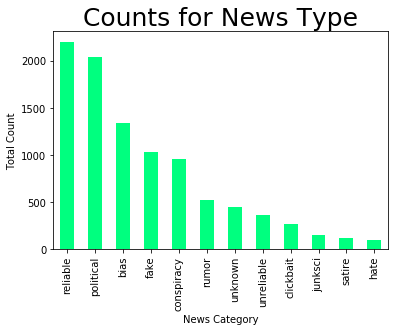

In [4]:
df.type.value_counts().plot(kind='bar', color='springgreen')
plt.xlabel('News Category')
plt.ylabel('Total Count')
plt.title("Counts for News Type", fontsize=25)
plt.savefig('newstypecounts.png', bbox_inches='tight', dpi = 300)

Text(0.5, 1.0, 'Counts for Domain')

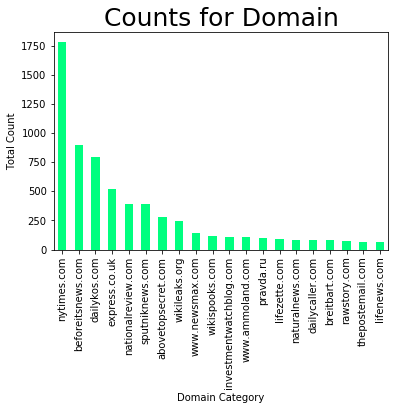

In [5]:
df.domain.value_counts().nlargest(20).plot(kind='bar', color='springgreen')
plt.xlabel('Domain Category')
plt.ylabel('Total Count')
plt.title("Counts for Domain", fontsize=25)

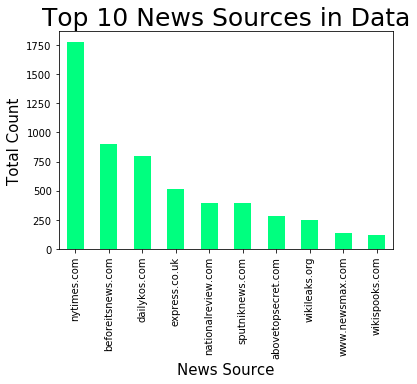

In [6]:
valcounts_domain = df.domain.value_counts()
topten_domain = valcounts_domain.head(10)
topten_domain.plot(kind='bar', color='springgreen')
plt.xlabel('News Source', fontsize=15)
plt.ylabel('Total Count', fontsize=15)
plt.title("Top 10 News Sources in Data", fontsize=25)
plt.savefig('top10newssources.png', bbox_inches='tight', dpi = 300)

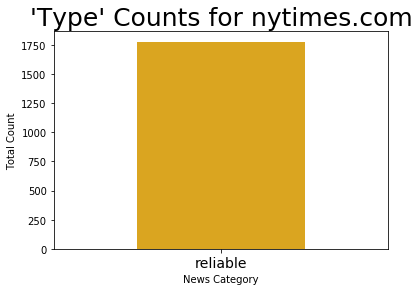

In [7]:
nytimes = df.loc[df['domain'] =='nytimes.com'] 
nytimes.type.value_counts().plot(kind='bar', color='goldenrod')
plt.xlabel('News Category')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=0)
plt.title("'Type' Counts for nytimes.com", fontsize=25)
plt.savefig('nytimes.png', bbox_inches='tight', dpi = 300)

The dataset defines every document from The New York Times as being 'reliable'.

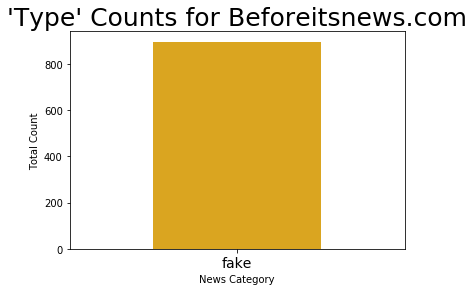

In [8]:
beforeitsnews = df.loc[df['domain'] =='beforeitsnews.com'] 
beforeitsnews.type.value_counts().plot(kind='bar', color='goldenrod')
plt.xlabel('News Category')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=0)
plt.title("'Type' Counts for Beforeitsnews.com", fontsize=25)
plt.savefig('beforeitsnews.png', bbox_inches='tight',  dpi = 300)

Similarly, every single article from beforeitsnews.com is considered to be 'fake' in the dataset. 

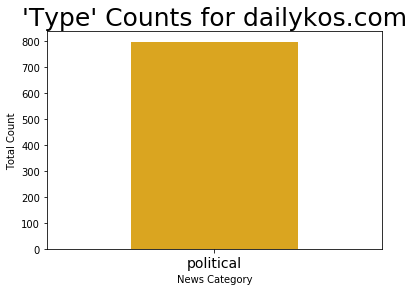

In [9]:
dailykos = df.loc[df['domain'] =='dailykos.com'] 
dailykos.type.value_counts().plot(kind='bar', color='goldenrod')
plt.xlabel('News Category')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=0)
plt.title("'Type' Counts for dailykos.com", fontsize=25)
plt.savefig('dailykos.png', bbox_inches='tight', dpi = 300)

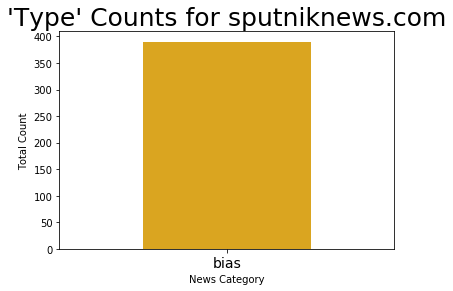

In [10]:
sputnik = df.loc[df['domain'] =='sputniknews.com'] 
sputnik.type.value_counts().plot(kind='bar', color='goldenrod')
plt.xlabel('News Category')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=0)
plt.title("'Type' Counts for sputniknews.com", fontsize=25)
plt.savefig('sputnik.png', bbox_inches='tight', dpi = 300)

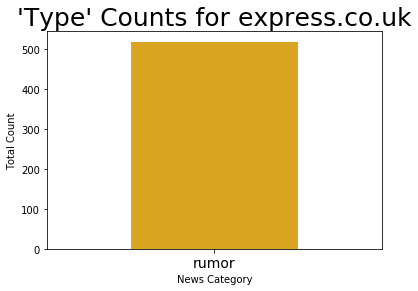

In [11]:
express = df.loc[df['domain'] =='express.co.uk'] 
express.type.value_counts().plot(kind='bar', color='goldenrod')
plt.xlabel('News Category')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=0)
plt.title("'Type' Counts for express.co.uk", fontsize=25)
plt.savefig('express.co.uk.png', bbox_inches='tight', dpi = 300)

It should be noted that there is inherent bias in this dataset from the labelling of every single article from a given source as being 'rumor', 'junksci', 'bias', or 'political', as opposed to 'reliable', as any given source will contain a wide variety of documents, with varying levels of veracity.

## Binary Labels

## 'Fake' vs. 'Reliable' news in dataset

In [12]:
df = pd.read_csv('complete_new_data.csv')

In [13]:
df.shape

(20000, 16)

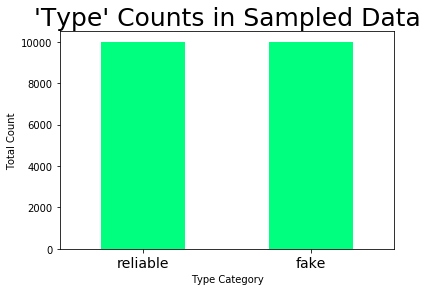

In [14]:
df.type.value_counts().plot(kind='bar', color='springgreen')
plt.xlabel('Type Category')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=0)
plt.title("'Type' Counts in Sampled Data", fontsize=25)
plt.savefig('typecounts.png', bbox_inches='tight', dpi = 300)

10,000 articles labeled 'fake' and '10,000' articles labelled 'reliable' have been sampled from the larger dataset. 

In [17]:
df = df.drop(['tags', 'summary', 'source'], axis=1)

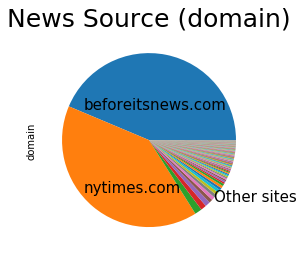

In [19]:
df.domain.value_counts().plot(kind='pie',labels= None)
plt.text(-0.75, 0.35, 'beforeitsnews.com', dict(size=15))
plt.text(-0.75, -0.6, 'nytimes.com', dict(size=15))
plt.text(0.75, -0.7, 'Other sites', dict(size=15))
plt.title("News Source (domain)", fontsize=25)
plt.savefig('newssourcepie.png', bbox_inches='tight', dpi = 300)

## Sentiment Analysis with VADER and textblob

In [20]:
fake = df[df['type']=='fake']

In [21]:
fake.shape

(10000, 13)

In [22]:
fakecontent = []
for index, row in fake.iterrows():
    fakecontent.append(row['content'])

In [23]:
print (len(fakecontent))

10000


In [24]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for doc in fakecontent:
    pol_score = sia.polarity_scores(doc)
    pol_score['content'] = doc
    results.append(pol_score)

In [25]:
fakedf = pd.DataFrame.from_records(results)

In [26]:
fakedf.head()

,compound,content,neg,neu,pos
0,0.9689,"(Before It's News)\n\nOkay, so I have had one ...",0.080,0.653,0.266
1,0.9946,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",0.014,0.914,0.072
2,0.9966,Headline: Bitcoin & Blockchain Searches Exceed...,0.004,0.898,0.098
3,-0.9949,Go for it\n\n(Before It's News)\n\nThe morning...,0.133,0.786,0.081
4,-0.9460,Irish bank flight quickens despite EU rescue\n...,0.085,0.856,0.059


In [27]:
fakedf['label'] = 0
fakedf.loc[fakedf['compound'] > 0.2, 'label'] = 1
fakedf.loc[fakedf['compound'] < -0.2, 'label'] = -1

In [28]:
fakedf.label.value_counts()

 1    5939
-1    3464
 0     597
Name: label, dtype: int64

In [29]:
print (fakedf['compound'].mean())

0.22222996999999992


In [30]:
print (fakedf['neg'].mean())

0.07293319999999968


In [31]:
print (fakedf['neu'].mean())

0.8347048000000006


In [32]:
print (fakedf['pos'].mean())

0.09234690000000038


In [33]:
def textblob_polarity_score(text):
    blob = TextBlob(text)
    return blob.sentiment[0]

In [34]:
fakedf["textblob_polarity_score"] = fakedf["content"].apply(textblob_polarity_score)

In [35]:
def textblob_subjectivity_score(text):
    blob = TextBlob(text)
    return blob.sentiment[1]

In [36]:
fakedf["textblob_subjectivity_score"] = fakedf["content"].apply(textblob_subjectivity_score)

In [37]:
fakedf['text_blob_polarity_label'] = 0
fakedf.loc[fakedf['textblob_polarity_score'] > 0.2, 'text_blob_polarity_label'] = 1
fakedf.loc[fakedf['textblob_polarity_score'] < -0.2, 'text_blob_polarity_label'] = -1

In [38]:
fakedf['text_blob_subjectivity_label'] = 0
fakedf.loc[fakedf['textblob_subjectivity_score'] > 0.55, 'text_blob_subjectivity_label'] = 1
fakedf.loc[fakedf['textblob_subjectivity_score'] < 0.45, 'text_blob_subjectivity_label'] = -1

In [39]:
fakedf[fakedf['textblob_subjectivity_score']>=.5].count()

compound                        2356
content                         2356
neg                             2356
neu                             2356
pos                             2356
label                           2356
textblob_polarity_score         2356
textblob_subjectivity_score     2356
text_blob_polarity_label        2356
text_blob_subjectivity_label    2356
dtype: int64

In [40]:
fakedf.text_blob_polarity_label.value_counts()

 0    8118
 1    1749
-1     133
Name: text_blob_polarity_label, dtype: int64

In [41]:
fakedf.text_blob_subjectivity_label.value_counts()

-1    5784
 0    3088
 1    1128
Name: text_blob_subjectivity_label, dtype: int64

In [42]:
print (fakedf['textblob_polarity_score'].mean())

0.1050328751697413


In [43]:
print (fakedf['textblob_subjectivity_score'].mean())

0.41753126695216386


In [44]:
reliable = df[df['type']=='reliable']

In [45]:
relcontent = []

In [46]:
for index, row in reliable.iterrows():
    relcontent.append(row['content'])

In [47]:
relresults = []
for doc in relcontent:
    pol_score = sia.polarity_scores(doc)
    pol_score['content'] = doc
    relresults.append(pol_score)

In [48]:
reldf = pd.DataFrame.from_records(relresults)



In [49]:
reldf['label'] = 0
reldf.loc[reldf['compound'] > 0.2, 'label'] = 1
reldf.loc[reldf['compound'] < -0.2, 'label'] = -1

In [50]:
reldf.label.value_counts()

 1    6721
-1    2581
 0     698
Name: label, dtype: int64

In [51]:
print (reldf['compound'].mean())

0.3772843899999984


In [52]:
print (reldf['neg'].mean())

0.05900119999999966


In [53]:
print (reldf['neu'].mean())

0.8484762999999974


In [54]:
print (reldf['pos'].mean())

0.09252050000000059


In [55]:
def textblob_polarity_score(text):
    blob = TextBlob(text)
    return blob.sentiment[0]

In [56]:
reldf["textblob_polarity_score"] = reldf["content"].apply(textblob_polarity_score)

In [57]:
def textblob_subjectivity_score(text):
    blob = TextBlob(text)
    return blob.sentiment[1]

In [58]:
reldf["textblob_subjectivity_score"] = reldf["content"].apply(textblob_subjectivity_score)

In [59]:
reldf['text_blob_polarity_label'] = 0
reldf.loc[reldf['textblob_polarity_score'] > 0.2, 'text_blob_polarity_label'] = 1
reldf.loc[reldf['textblob_polarity_score'] < -0.2, 'text_blob_polarity_label'] = -1

In [60]:
reldf['text_blob_subjectivity_label'] = 0
reldf.loc[reldf['textblob_subjectivity_score'] > 0.55, 'text_blob_subjectivity_label'] = 1
reldf.loc[reldf['textblob_subjectivity_score'] < 0.45, 'text_blob_subjectivity_label'] = -1

In [61]:
reldf[reldf['textblob_subjectivity_score']>=.5].count()

compound                        1715
content                         1715
neg                             1715
neu                             1715
pos                             1715
label                           1715
textblob_polarity_score         1715
textblob_subjectivity_score     1715
text_blob_polarity_label        1715
text_blob_subjectivity_label    1715
dtype: int64

In [62]:
reldf.text_blob_polarity_label.value_counts()

 0    8752
 1    1175
-1      73
Name: text_blob_polarity_label, dtype: int64

In [63]:
reldf.text_blob_subjectivity_label.value_counts()

-1    6800
 0    2438
 1     762
Name: text_blob_subjectivity_label, dtype: int64

In [64]:
print (reldf['textblob_polarity_score'].mean())

0.09809097950087405


In [65]:
print (reldf['textblob_subjectivity_score'].mean())

0.40756980415620375


## Classification (Predictive Analysis)

First, some text cleaning is involved. Various steps are outlined below. 

Tokenize article text.

In [66]:
df.head()

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description
0,6046549,beforeitsnews.com,fake,http://beforeitsnews.com/family/2012/05/mother...,"(Before It's News)\n\nOkay, so I have had one ...",2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Mother’s Day Weekend WINNERS!,Brandy At,NaN,[''],NaN
1,2883242,beforeitsnews.com,fake,http://beforeitsnews.com/economics-and-politic...,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",2017-11-18T20:01:27.400599,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",NaN,NaN,[''],NaN
2,797849,beforeitsnews.com,fake,http://beforeitsnews.com/press-releases/2012/0...,Headline: Bitcoin & Blockchain Searches Exceed...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Barona Band of Mission Indians Commemorates 80...,NaN,NaN,[''],NaN
3,7141957,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2015/09/go-fo...,Go for it\n\n(Before It's News)\n\nThe morning...,2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Go for it,Greater Fool,NaN,[''],NaN
4,4669035,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2011/02/irish...,Irish bank flight quickens despite EU rescue\n...,2017-11-27T01:14:08.7454,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Irish bank flight quickens despite EU rescue,Josey Wales,NaN,[''],NaN


In [67]:
punctuation = string.punctuation

Remove punctuation and stem the words. 

In [68]:
def remove_punc(row):
    tokens = row.split()
    newtokens = [w for w in tokens if w.isalpha()]
    newtokens = [w for w in newtokens if w not in punctuation]
    return newtokens

In [69]:
df['no_punc_content'] = df.content.apply(remove_punc)

In [70]:
ps = PorterStemmer()

def stemmed_content(row):
    content = row['no_punc_content']
    stemmed_list = [ps.stem(word) for word in content]
    return (stemmed_list)

df['stemmed_words'] = df.apply(stemmed_content, axis=1)

df.head()

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,no_punc_content,stemmed_words
0,6046549,beforeitsnews.com,fake,http://beforeitsnews.com/family/2012/05/mother...,"(Before It's News)\n\nOkay, so I have had one ...",2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Mother’s Day Weekend WINNERS!,Brandy At,NaN,[''],NaN,"[so, I, have, had, one, terrible, another, pos...","[so, I, have, had, one, terribl, anoth, post, ..."
1,2883242,beforeitsnews.com,fake,http://beforeitsnews.com/economics-and-politic...,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",2017-11-18T20:01:27.400599,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",NaN,NaN,[''],NaN,"[Stocks, in, Review, by, Crown, Equity, Holdin...","[stock, in, review, by, crown, equiti, hold, c..."
2,797849,beforeitsnews.com,fake,http://beforeitsnews.com/press-releases/2012/0...,Headline: Bitcoin & Blockchain Searches Exceed...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Barona Band of Mission Indians Commemorates 80...,NaN,NaN,[''],NaN,"[Bitcoin, Blockchain, Searches, Exceed, Blockc...","[bitcoin, blockchain, search, exce, blockchain..."
3,7141957,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2015/09/go-fo...,Go for it\n\n(Before It's News)\n\nThe morning...,2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Go for it,Greater Fool,NaN,[''],NaN,"[Go, for, it, The, morning, after, the, mornin...","[Go, for, it, the, morn, after, the, morn, we,..."
4,4669035,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2011/02/irish...,Irish bank flight quickens despite EU rescue\n...,2017-11-27T01:14:08.7454,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Irish bank flight quickens despite EU rescue,Josey Wales,NaN,[''],NaN,"[Irish, bank, flight, quickens, despite, EU, r...","[irish, bank, flight, quicken, despit, EU, res..."


**Remove stop words**

In [71]:
english_stopwords = set(stopwords.words('english'))


def remove_stop(row):
    tokens = row['stemmed_words']
    newtokens = [w for w in tokens if w not in english_stopwords]
    return newtokens

df['no_stop_stemmed'] = df.apply(remove_stop, axis=1)



df.head()

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,no_punc_content,stemmed_words,no_stop_stemmed
0,6046549,beforeitsnews.com,fake,http://beforeitsnews.com/family/2012/05/mother...,"(Before It's News)\n\nOkay, so I have had one ...",2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Mother’s Day Weekend WINNERS!,Brandy At,NaN,[''],NaN,"[so, I, have, had, one, terrible, another, pos...","[so, I, have, had, one, terribl, anoth, post, ...","[I, one, terribl, anoth, post, one, I, plan, T..."
1,2883242,beforeitsnews.com,fake,http://beforeitsnews.com/economics-and-politic...,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",2017-11-18T20:01:27.400599,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",NaN,NaN,[''],NaN,"[Stocks, in, Review, by, Crown, Equity, Holdin...","[stock, in, review, by, crown, equiti, hold, c...","[stock, review, crown, equiti, hold, crown, eq..."
2,797849,beforeitsnews.com,fake,http://beforeitsnews.com/press-releases/2012/0...,Headline: Bitcoin & Blockchain Searches Exceed...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Barona Band of Mission Indians Commemorates 80...,NaN,NaN,[''],NaN,"[Bitcoin, Blockchain, Searches, Exceed, Blockc...","[bitcoin, blockchain, search, exce, blockchain...","[bitcoin, blockchain, search, exce, blockchain..."
3,7141957,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2015/09/go-fo...,Go for it\n\n(Before It's News)\n\nThe morning...,2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Go for it,Greater Fool,NaN,[''],NaN,"[Go, for, it, The, morning, after, the, mornin...","[Go, for, it, the, morn, after, the, morn, we,...","[Go, morn, morn, know, next, prime, minist, ba..."
4,4669035,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2011/02/irish...,Irish bank flight quickens despite EU rescue\n...,2017-11-27T01:14:08.7454,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Irish bank flight quickens despite EU rescue,Josey Wales,NaN,[''],NaN,"[Irish, bank, flight, quickens, despite, EU, r...","[irish, bank, flight, quicken, despit, EU, res...","[irish, bank, flight, quicken, despit, EU, res..."


The following steps create a predictive model using count vectorizer and Multinomial Naive Bayes.  These are in individual steps.  All subsequent predictive models are made using the sklearn pipeline class. 

Rejoin lists of words in the 'no_stop_stemmed' column.

In [72]:
def rejoin(row):
    my_list = row['no_stop_stemmed']
    joined_text = ( " ".join(my_list))
    return joined_text

df['pre_processed_text'] = df.apply(rejoin, axis=1)

df.head()

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,no_punc_content,stemmed_words,no_stop_stemmed,pre_processed_text
0,6046549,beforeitsnews.com,fake,http://beforeitsnews.com/family/2012/05/mother...,"(Before It's News)\n\nOkay, so I have had one ...",2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Mother’s Day Weekend WINNERS!,Brandy At,NaN,[''],NaN,"[so, I, have, had, one, terrible, another, pos...","[so, I, have, had, one, terribl, anoth, post, ...","[I, one, terribl, anoth, post, one, I, plan, T...",I one terribl anoth post one I plan To end wee...
1,2883242,beforeitsnews.com,fake,http://beforeitsnews.com/economics-and-politic...,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",2017-11-18T20:01:27.400599,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",NaN,NaN,[''],NaN,"[Stocks, in, Review, by, Crown, Equity, Holdin...","[stock, in, review, by, crown, equiti, hold, c...","[stock, review, crown, equiti, hold, crown, eq...",stock review crown equiti hold crown equiti ho...
2,797849,beforeitsnews.com,fake,http://beforeitsnews.com/press-releases/2012/0...,Headline: Bitcoin & Blockchain Searches Exceed...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Barona Band of Mission Indians Commemorates 80...,NaN,NaN,[''],NaN,"[Bitcoin, Blockchain, Searches, Exceed, Blockc...","[bitcoin, blockchain, search, exce, blockchain...","[bitcoin, blockchain, search, exce, blockchain...",bitcoin blockchain search exce blockchain stoc...
3,7141957,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2015/09/go-fo...,Go for it\n\n(Before It's News)\n\nThe morning...,2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Go for it,Greater Fool,NaN,[''],NaN,"[Go, for, it, The, morning, after, the, mornin...","[Go, for, it, the, morn, after, the, morn, we,...","[Go, morn, morn, know, next, prime, minist, ba...",Go morn morn know next prime minist bank canad...
4,4669035,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2011/02/irish...,Irish bank flight quickens despite EU rescue\n...,2017-11-27T01:14:08.7454,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Irish bank flight quickens despite EU rescue,Josey Wales,NaN,[''],NaN,"[Irish, bank, flight, quickens, despite, EU, r...","[irish, bank, flight, quicken, despit, EU, res...","[irish, bank, flight, quicken, despit, EU, res...",irish bank flight quicken despit EU rescu depo...


In [73]:
df.type.unique()

array(['fake', 'reliable'], dtype=object)

In [74]:
df = df.dropna(subset=['type'])

In [75]:
df.type.unique()

array(['fake', 'reliable'], dtype=object)

In [76]:
y = df.type

Split the data into training and testing data. 

In [77]:
X_train, X_test, y_train, y_test = train_test_split(df['pre_processed_text'], y, test_size=0.33, random_state=53)

Create Count Vectorizer.

In [78]:
count_vectorizer = CountVectorizer(stop_words='english')

In [79]:
count_train = count_vectorizer.fit_transform(X_train)

count_test = count_vectorizer.transform(X_test)

In [80]:
print(count_vectorizer.get_feature_names()[:100])

['aa', 'aaa', 'aab', 'aabgu', 'aac', 'aachen', 'aadmi', 'aadvantag', 'aae', 'aafia', 'aafp', 'aagot', 'aakash', 'aakrosh', 'aal', 'aalborg', 'aalim', 'aaltci', 'aalto', 'aam', 'aaman', 'aamaq', 'aamer', 'aamet', 'aamir', 'aamoth', 'aan', 'aanbevel', 'aanbevelingen', 'aantoonbaar', 'aap', 'aapl', 'aar', 'aardman', 'aarhu', 'aaron', 'aaronson', 'aarp', 'aasan', 'aastrom', 'aau', 'aav', 'ab', 'aba', 'ababa', 'ababneh', 'aback', 'abacu', 'abaddon', 'abadi', 'abadin', 'abadiânia', 'abagnal', 'abaixo', 'abalamo', 'abalo', 'abalon', 'abandon', 'abash', 'abasi', 'abat', 'abatti', 'abattoir', 'abaya', 'abb', 'abba', 'abbado', 'abbeel', 'abbey', 'abbi', 'abbot', 'abbott', 'abboud', 'abbrevi', 'abbruzzes', 'abbvi', 'abc', 'abcam', 'abd', 'abdallah', 'abdel', 'abdelatti', 'abdelhakim', 'abdeljab', 'abdellatif', 'abdelmonem', 'abdelrahman', 'abderakhman', 'abderrahim', 'abdeslam', 'abdessalaam', 'abdi', 'abdiasi', 'abdic', 'abdikadir', 'abdin', 'abdirahman', 'abdirisak', 'abdisamad', 'abdomen']


**Train and test the model**

In [81]:
nb_classifier = MultinomialNB()


nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)


score = metrics.accuracy_score(y_test, pred)
print(score)

0.8671212121212121


In [82]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [83]:
show_most_informative_features(count_vectorizer, nb_classifier)

	-14.1713	aac            		-4.2017	wa             
	-14.1713	aae            		-4.5269	hi             
	-14.1713	aafia          		-4.6422	ha             
	-14.1713	aafp           		-4.6732	new            
	-14.1713	aakash         		-4.7910	said           
	-14.1713	aaltci         		-5.0097	thi            
	-14.1713	aamer          		-5.2696	continu        
	-14.1713	aamet          		-5.3058	stori          
	-14.1713	aamir          		-5.3252	read           
	-14.1713	aan            		-5.3520	main           
	-14.1713	aanbevel       		-5.3822	york           
	-14.1713	aanbevelingen  		-5.3951	pleas          
	-14.1713	aantoonbaar    		-5.4519	like           
	-14.1713	aastrom        		-5.4638	time           
	-14.1713	aav            		-5.6148	sign           
	-14.1713	aba            		-5.7596	advertis       
	-14.1713	ababa          		-5.7871	year           
	-14.1713	ababneh        		-5.8000	newslett       
	-14.1713	abaddon        		-5.8677	peopl          
	-14.1713	abadi          		-5.8

Many of the most predictive features (on the right hand column above) are linked specifically to the New York Times. Let's extend the stopwords for different results.

The English stopwords included in scikit-learn:

In [84]:
print (text.ENGLISH_STOP_WORDS)

frozenset({'mostly', 'whom', 'nowhere', 'per', 'she', 'thin', 'were', 'other', 'bottom', 'cry', 'such', 'thick', 'was', 'beyond', 'again', 'amount', 'give', 'it', 'thereafter', 'latter', 'even', 'never', 'own', 'side', 'either', 'they', 'too', 'am', 'back', 'could', 'fire', 'becoming', 'my', 'who', 'has', 'un', 'those', 'up', 'here', 'whither', 'also', 'this', 'next', 'describe', 'anyhow', 'sometime', 'off', 'her', 'ours', 'which', 'after', 'hereafter', 'where', 'although', 'find', 'many', 'by', 'ever', 'no', 'of', 'to', 'someone', 'often', 'about', 'that', 'if', 'in', 'ten', 'fill', 'interest', 'afterwards', 'everywhere', 'somehow', 'themselves', 'least', 'together', 'sixty', 'first', 'hers', 'neither', 'towards', 'top', 'whatever', 'these', 'without', 'whose', 'will', 'fifty', 'beforehand', 'not', 'five', 'thereupon', 'eight', 'therefore', 'yourself', 'name', 'formerly', 'while', 'around', 'onto', 'hereupon', 'somewhere', 'hasnt', 'detail', 'among', 'anyone', 'whereupon', 'amoungst',

Let's extend this:

In [85]:
additional_sw = ('new', 'york', 'time', 'continu', 'read', 'stori','wa','hi','ha','pleas','like','newslett','view')

In [86]:
all_stop_words = text.ENGLISH_STOP_WORDS.union(additional_sw)


Redo analysis:

In [87]:
count_vectorizer = CountVectorizer(stop_words=all_stop_words)
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [88]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print(score)

0.8712121212121212


In [89]:
show_most_informative_features(count_vectorizer, nb_classifier)

	-14.0851	aac            		-4.7049	said           
	-14.0851	aae            		-4.9235	thi            
	-14.0851	aafia          		-5.2659	main           
	-14.0851	aafp           		-5.5287	sign           
	-14.0851	aakash         		-5.6735	advertis       
	-14.0851	aaltci         		-5.7010	year           
	-14.0851	aamer          		-5.7816	peopl          
	-14.0851	aamet          		-5.7861	tri            
	-14.0851	aamir          		-5.7908	state          
	-14.0851	aan            		-5.8054	make           
	-14.0851	aanbevel       		-5.8747	work           
	-14.0851	aanbevelingen  		-5.9483	offer          
	-14.0851	aantoonbaar    		-5.9898	use            
	-14.0851	aastrom        		-5.9923	say            
	-14.0851	aav            		-6.0077	mani           
	-14.0851	aba            		-6.0105	becaus         
	-14.0851	ababa          		-6.0243	receiv         
	-14.0851	ababneh        		-6.0249	onli           
	-14.0851	abaddon        		-6.0456	includ         
	-14.0851	abadi          		-6.0

### Classification Using a Pipeline ##

The above steps can also be completed conveniently using a pipeline.

Pipeline with count_vectorizer() using several classifiers. 

In [90]:
classifiers = [MultinomialNB(),LinearSVC(), XGBClassifier()]

In [91]:
class pre_process(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def transform(self, X, y=None):
        
        def proc(z):
            text = z.split()
            text =  [w for w in text if w.isalpha()]
            text = [w for w in text if w not in punctuation]
            text = [ps.stem(word) for word in text]
            text = [w for w in text if w not in english_stopwords]
            text = " ".join(text)
            return text
        z = X.apply(proc)        
        return z
    def fit(self, df, y=None):
        return self

In [92]:
X_train, X_test, y_train, y_test = train_test_split(df['pre_processed_text'], y, test_size=0.33, random_state=53)

In [93]:
for classifier in classifiers:
    tfidf_pineline = Pipeline([
        #('preproc', pre_process()),
              ('cv', CountVectorizer(stop_words='english')),
              ('clf',  classifier  )])
    tfidf_pineline.fit(X_train,y_train)
    y_pred = tfidf_pineline.predict(X_test)
    print ("\n\nName of classifier being used with tfidf vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(tfidf_pineline.score(X_test,y_test)))



Name of classifier being used with tfidf vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.87      0.87      0.87      3346
    reliable       0.86      0.87      0.87      3254

    accuracy                           0.87      6600
   macro avg       0.87      0.87      0.87      6600
weighted avg       0.87      0.87      0.87      6600


 Accuracy of classifier : 0.8671212121212121


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




Name of classifier being used with tfidf vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.87      0.88      0.87      3346
    reliable       0.87      0.86      0.87      3254

    accuracy                           0.87      6600
   macro avg       0.87      0.87      0.87      6600
weighted avg       0.87      0.87      0.87      6600


 Accuracy of classifier : 0.8713636363636363


Name of classifier being used with tfidf vectorizer: 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators

**Same but with tf-idf**

Use sklearn pipeline to create model using tf-idf vectorizer.

In [94]:
for classifier in classifiers:
    tfidf_pineline = Pipeline([
        #('preproc', pre_process()),
              ('cv', TfidfVectorizer()),
              ('clf',  classifier  )])
    tfidf_pineline.fit(X_train,y_train)
    y_pred = tfidf_pineline.predict(X_test)
    print ("\n\nName of classifier being used with tfidf vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(tfidf_pineline.score(X_test,y_test)))



Name of classifier being used with tfidf vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.92      0.82      0.87      3346
    reliable       0.83      0.93      0.88      3254

    accuracy                           0.87      6600
   macro avg       0.88      0.87      0.87      6600
weighted avg       0.88      0.87      0.87      6600


 Accuracy of classifier : 0.8727272727272727


Name of classifier being used with tfidf vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.90      0.92      0.91      3346
    reliable       0.92      0.89      0.91      3254

    ac

As noted above, these steps can also be completed without using a pipeline. Steps are repeated below in order to make use of the sbow_most_informative_features() function with the Linear SVC classifier, which was the most accurate.

In [95]:
tfidf_vect = TfidfVectorizer()

X_tfidf_train = tfidf_vect.fit_transform(X_train)

X_tfidf_test = tfidf_vect.transform(X_test)

clf = LinearSVC()

clf.fit(X_tfidf_train, y_train)
pred = clf.predict(X_tfidf_test)

score = metrics.accuracy_score(y_test, pred)
print(score)

0.9075757575757576


In [96]:
show_most_informative_features(tfidf_vect, nb_classifier)

	-14.0851	aac            		-4.7049	sacr           
	-14.0851	aae            		-4.9235	thecas         
	-14.0851	aafia          		-5.2659	magnolia       
	-14.0851	aafp           		-5.5287	sibal          
	-14.0851	aakash         		-5.6735	advert         
	-14.0851	aaltci         		-5.7010	xylophon       
	-14.0851	aamer          		-5.7816	pellet         
	-14.0851	aamet          		-5.7861	transunion     
	-14.0851	aamir          		-5.7908	stamina        
	-14.0851	aan            		-5.8054	mahom          
	-14.0851	aanbevel       		-5.8747	wma            
	-14.0851	aanbevelingen  		-5.9483	ochocinco      
	-14.0851	aantoonbaar    		-5.9898	upmarket       
	-14.0851	aastrom        		-5.9923	satin          
	-14.0851	aav            		-6.0077	manag          
	-14.0851	aba            		-6.0105	beaverton      
	-14.0851	ababa          		-6.0243	reaganit       
	-14.0851	ababneh        		-6.0249	olugbala       
	-14.0851	abaddon        		-6.0456	inactiv        
	-14.0851	abadi          		-6.0

**Tf-idf with bigrams**

In [97]:
classifiers = [MultinomialNB(),LinearSVC(), XGBClassifier()]

In [98]:
for classifier in classifiers:
    tfidf_pineline_w_bigrams = Pipeline([
        #('preproc', pre_process()),
              ('cv', TfidfVectorizer(ngram_range=(2,2))),
              ('clf',   classifier)])
    tfidf_pineline_w_bigrams.fit(X_train,y_train)
    y_pred = tfidf_pineline_w_bigrams.predict(X_test)
    print ("\n\nName of classifier being used with tfidf vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(tfidf_pineline_w_bigrams.score(X_test,y_test)))



Name of classifier being used with tfidf vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.95      0.85      0.90      3346
    reliable       0.86      0.96      0.91      3254

    accuracy                           0.90      6600
   macro avg       0.91      0.91      0.90      6600
weighted avg       0.91      0.90      0.90      6600


 Accuracy of classifier : 0.9046969696969697


Name of classifier being used with tfidf vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.89      0.96      0.92      3346
    reliable       0.95      0.88      0.91      3254

    ac

In [99]:
for classifier in classifiers:
    tfidf_pineline_w_trigrams = Pipeline([
              ('cv', TfidfVectorizer(ngram_range=(3,3))),
              ('clf',   classifier)])
    tfidf_pineline_w_trigrams.fit(X_train,y_train)
    y_pred = tfidf_pineline_w_trigrams.predict(X_test)
    print ("\n\nName of classifier being used with tfidf vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(tfidf_pineline_w_trigrams.score(X_test,y_test)))



Name of classifier being used with tfidf vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.94      0.81      0.87      3346
    reliable       0.83      0.94      0.88      3254

    accuracy                           0.88      6600
   macro avg       0.88      0.88      0.88      6600
weighted avg       0.88      0.88      0.87      6600


 Accuracy of classifier : 0.8754545454545455


Name of classifier being used with tfidf vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.82      0.96      0.89      3346
    reliable       0.95      0.79      0.86      3254

    ac

Vectorization with trigrams is significantly less accurate than with bigrams. 

The td-idf vectorizer with SVM was the most accurate.  It is implemented below without the sklearn pipeline to get the most informative features. 

In [100]:
tfidf_vect_bigrams = TfidfVectorizer(ngram_range=(2,2))

In [101]:
X_tfidf__bigrams_train = tfidf_vect_bigrams.fit_transform(X_train)

In [102]:
X_tfidf__bigrams_test = tfidf_vect_bigrams.transform(X_test)

In [103]:
linsvc = LinearSVC()

In [104]:
linsvc.fit(X_tfidf__bigrams_train, y_train)
pred = linsvc.predict(X_tfidf__bigrams_test)

In [105]:
score = metrics.accuracy_score(y_test, pred)
print(score)

0.9172727272727272


In [106]:
show_most_informative_features(tfidf_vect_bigrams, linsvc)

	-4.5960	think thi      		6.2862	main stori     
	-4.5277	add two        		6.2685	read main      
	-4.5130	stori add      		5.9580	advertis continu
	-4.5052	reader think   		5.6588	continu read   
	-4.4259	thi stori      		4.7699	new york       
	-2.7212	appear first   		4.2447	to re          
	-2.6345	bitcoin blockchain		2.3737	an articl      
	-2.6103	blockchain search		1.9920	next in        
	-2.6103	blockchain stock		1.7252	said would     
	-2.6103	exce blockchain		1.6790	belov husband  
	-2.6103	search exce    		1.4953	he wa          
	-1.4449	tea parti      		1.4365	said wa        
	-1.2497	thi articl     		1.4229	view photo     
	-1.2348	year old       		1.4056	wife late      
	-1.2196	read full      		1.4014	belov wife     
	-1.1884	mainstream media		1.3212	thomson reuter 
	-1.1396	thi one        		1.3148	becaus edit    
	-1.1156	thi mean       		1.3007	in lieu        
	-1.1107	presid donald  		1.2746	associ press   
	-1.1003	thi video      		1.2613	servic held    
	-1.0742	man

The above results show that bigrams relating directly to the newspaper the New York Times are most predictive.  This is problematic because we want the classifier to predict whether an article is fake or reliable -- not whether it appeared in the New York Times.

There are a few ways this issue can be approached -- we can include more stopwords relating specifically to the New York Times, or we can resample the data to include more sources.

Let's redo this including stop words relating specifically to the New York Times. 

In [107]:
tfidf_vect_bigrams = TfidfVectorizer(ngram_range=(2,2),stop_words=all_stop_words )

In [108]:
X_tfidf__bigrams_train = tfidf_vect_bigrams.fit_transform(X_train)
X_tfidf__bigrams_test = tfidf_vect_bigrams.transform(X_test)

In [109]:
linsvc = LinearSVC()
linsvc.fit(X_tfidf__bigrams_train, y_train)
pred = linsvc.predict(X_tfidf__bigrams_test)

In [110]:
score = metrics.accuracy_score(y_test, pred)
print(score)

0.9106060606060606


In [111]:
show_most_informative_features(tfidf_vect_bigrams, linsvc)

	-6.6677	think thi      		12.0724	advertis main  
	-6.6645	thi add        		1.9519	subscrib sign  
	-6.6529	reader think   		1.9056	verifi robot   
	-2.8440	bitcoin blockchain		1.9056	updat special  
	-2.8165	blockchain search		1.9056	select subscrib
	-2.8165	blockchain stock		1.9056	robot click    
	-2.8165	exce blockchain		1.9056	receiv occasion
	-2.8165	search exce    		1.9056	occasion updat 
	-1.6201	tea parti      		1.9056	invalid email  
	-1.5319	thi articl     		1.9056	error tri      
	-1.4644	thi mean       		1.9056	email select   
	-1.4423	year old       		1.9056	click invalid  
	-1.3989	thi post       		1.9056	agre receiv    
	-1.3828	follow twitter 		1.8932	thank error    
	-1.3479	mainstream media		1.8592	offer product  
	-1.3436	thi video      		1.8413	special offer  
	-1.2469	fals flag      		1.8317	sign main      
	-1.2438	presid donald  		1.8317	product thank  
	-1.1968	facebook twitter		1.8271	sign agre      
	-1.1481	mani peopl     		1.7497	main verifi    
	-1.1207	so

Many of these features are still clearly associated with New York times subscription. Let's try including a few more stopwords and doing the analysis again.

In [112]:
more_sw = ('advertis','subscrib','main','email','thank','sign','verifi','robot','updat','click','select','offer','new', 'york', 'time', 'continu', 'read', 'stori','wa','hi','ha','pleas','like','newslett','view')

all_stop_words = text.ENGLISH_STOP_WORDS.union(more_sw)


In [113]:
tfidf_vect_bigrams = TfidfVectorizer(ngram_range=(2,2),stop_words=all_stop_words )
X_tfidf__bigrams_train = tfidf_vect_bigrams.fit_transform(X_train)
X_tfidf__bigrams_test = tfidf_vect_bigrams.transform(X_test)

In [114]:
linsvc = LinearSVC()
linsvc.fit(X_tfidf__bigrams_train, y_train)
pred = linsvc.predict(X_tfidf__bigrams_test)

In [115]:
score = metrics.accuracy_score(y_test, pred)
print(score)

0.8963636363636364


In [116]:
show_most_informative_features(tfidf_vect_bigrams, linsvc)

	-7.1232	thi add        		4.8270	special product
	-7.1145	reader think   		4.8270	receiv occasion
	-7.1106	think thi      		4.8270	occasion special
	-3.0562	bitcoin blockchain		4.8270	error tri      
	-3.0266	blockchain search		4.8270	agre receiv    
	-3.0266	blockchain stock		4.7725	invalid agre   
	-3.0266	exce blockchain		4.7717	product error  
	-3.0266	search exce    		1.7511	presid bush    
	-1.7299	tea parti      		1.7038	offici said    
	-1.7033	thi articl     		1.6941	chief execut   
	-1.6085	thi mean       		1.5815	belov husband  
	-1.5642	year old       		1.4579	long island    
	-1.5231	follow twitter 		1.4500	nov est        
	-1.5098	thi post       		1.4228	servic held    
	-1.4580	mainstream media		1.4161	high school    
	-1.4540	thi video      		1.3937	belov wife     
	-1.4252	facebook twitter		1.3664	web site       
	-1.3425	fals flag      		1.3368	memori servic  
	-1.2993	presid donald  		1.3333	vice presid    
	-1.2207	social media   		1.3300	refer incorrectli
	-1.2170	

While slightly less accurate, some of these features appear to be more relefective of the content of news articles, rather than whether a given article was found in the New York Times. 


Now, let's try the approach of undersampling the data, so that fewer articles from the New York Times are in the dataset. 

### Predictive Analysis with domain considered

In [117]:
df.type.value_counts()

reliable    10000
fake        10000
Name: type, dtype: int64

In [118]:
df.domain.value_counts()

beforeitsnews.com              8733
nytimes.com                    8057
threepercenternation.com        267
thenet24h.com                   210
www.reuters.com                 187
www.yahoo.com                   133
www.sfgate.com                  121
theinternetpost.net             115
coed.com                        113
christianpost.com               107
www.chron.com                    93
news.yahoo.com                   93
thefreepatriot.org               84
indianexpress.com                60
thetruthdivision.com             57
uk.finance.yahoo.com             55
www.huffingtonpost.com           52
newswithviews.com                49
therightscoop.com                46
abcnews.go.com                   44
www.msn.com                      44
uk.reuters.com                   43
sports.yahoo.com                 42
nutritionfacts.org               39
consortiumnews.com               33
www.theguardian.com              32
www.businessinsider.com          31
realnewsrightnow.com        

NYT and Beforeitsnews are vastly overrepresented in the data. Let's preform undersampling.

Because the unbalanced larger classes are usually undersampled to the number of rows in the smallest represented classes, let's only include observations with domain classes that are represented at least 100 times in the dataset. There are 10 such classes. 

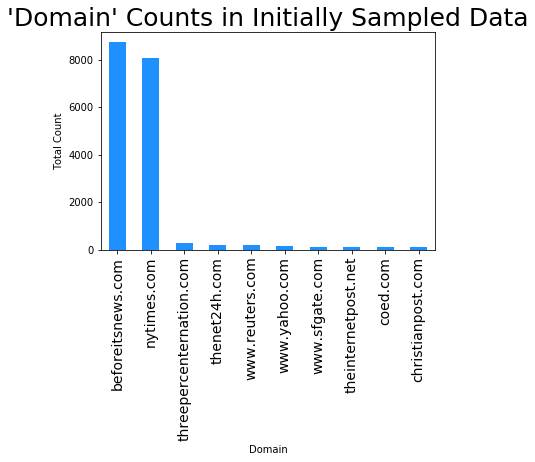

In [129]:
df.domain.value_counts().nlargest(10).plot(kind='bar', color='dodgerblue')
plt.xlabel('Domain')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=90)
plt.title("'Domain' Counts in Initially Sampled Data", fontsize=25)
plt.savefig('domaincounts.png', bbox_inches='tight', dpi = 300)

In [130]:
df.domain.value_counts().nlargest(10)

beforeitsnews.com           8733
nytimes.com                 8057
threepercenternation.com     267
thenet24h.com                210
www.reuters.com              187
www.yahoo.com                133
www.sfgate.com               121
theinternetpost.net          115
coed.com                     113
christianpost.com            107
Name: domain, dtype: int64

NYT and Beforeitsnews are vastly overrepresented in the data. Let's preform undersampling.

In [139]:
grouped = df.groupby('domain', group_keys=False)

In [140]:
balanced_df = pd.DataFrame(g.apply(lambda x: x.sample(grouped.size().min()))).reset_index(drop=True)

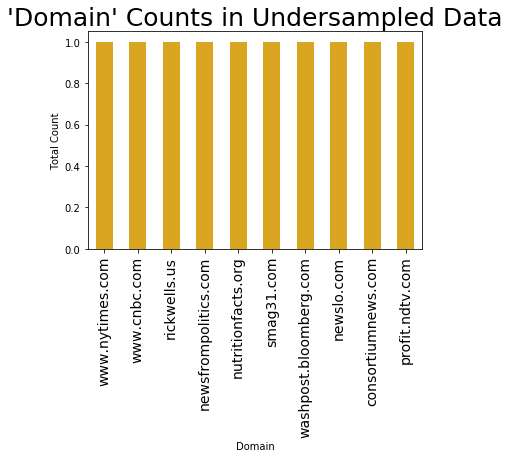

In [142]:
balanced_df.domain.value_counts().nlargest(10).plot(kind='bar', color='goldenrod')
plt.xlabel('Domain')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=90)
plt.title("'Domain' Counts in Undersampled Data", fontsize=25)
plt.savefig('domaincounts_under.png', bbox_inches='tight', dpi = 300)

We could also just undersample the two most overrepresented classes for domain, although this approach is less common.

In [143]:
nyt = df[df['domain'] == "nytimes.com"]

In [144]:
nyt_sample = nyt.sample(100)

In [145]:
mask = df['domain'].isin(['nytimes.com', 'beforeitsnews.com'])
newdf = df[~mask]

In [146]:
bef = df[df['domain'] == "beforeitsnews.com"]

In [147]:
bef_sample = bef.sample(100)

In [148]:
df_undersampling = pd.concat([newdf, nyt_sample, bef_sample], axis=0)

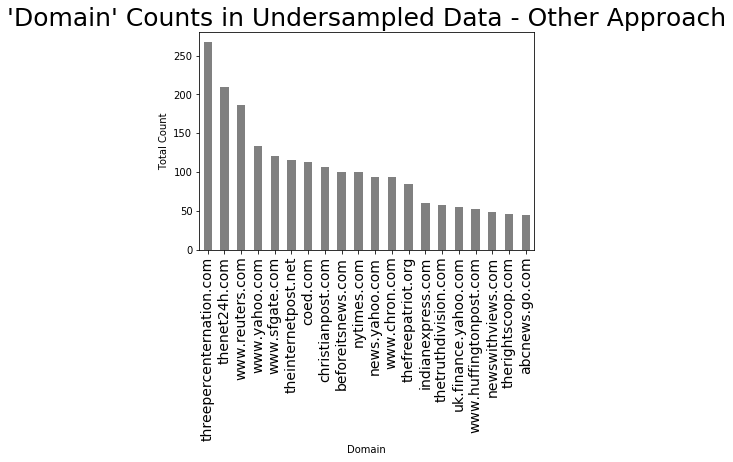

In [149]:
df_undersampling.domain.value_counts().nlargest(20).plot(kind='bar', color='grey')
plt.xlabel('Domain')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=90)
plt.title("'Domain' Counts in Undersampled Data - Other Approach", fontsize=25)
plt.savefig('domaincounts_under2.png', bbox_inches='tight', dpi = 300)

Let's first base the analysis on the standard approach for undersampling. 

In [150]:
y = balanced_df['type']

In [151]:
X_train, X_test, y_train, y_test = train_test_split(balanced_df['content'], y, test_size=0.33, random_state=53)



In [152]:
stopwords = stopwords.words('english')

In [153]:
for classifier in classifiers:
    countvect_pipeline = Pipeline([('preproc', pre_process()),
              ('cv', CountVectorizer(stop_words=stopwords)),
              ('clf',   classifier)])
    countvect_pipeline.fit(X_train,y_train)
    y_pred = countvect_pipeline.predict(X_test)
    print ("\n\nName of classifier being used with count vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(countvect_pipeline.score(X_test,y_test)))



Name of classifier being used with count vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.63      0.60      0.62        20
    reliable       0.71      0.74      0.73        27

    accuracy                           0.68        47
   macro avg       0.67      0.67      0.67        47
weighted avg       0.68      0.68      0.68        47


 Accuracy of classifier : 0.6808510638297872


Name of classifier being used with count vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.61      0.85      0.71        20
    reliable       0.84      0.59      0.70        27

    ac

In [154]:
for classifier in classifiers:
    tfidf_pipeline = Pipeline([
        #('preproc', pre_process()),
              ('tfidf', TfidfVectorizer(stop_words=stopwords)),
              ('clf',   classifier)])
    tfidf_pipeline.fit(X_train,y_train)
    y_pred = tfidf_pipeline.predict(X_test)
    print ("\n\nName of classifier being used with tfidf vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(tfidf_pipeline.score(X_test,y_test)))



Name of classifier being used with tfidf vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.50      0.05      0.09        20
    reliable       0.58      0.96      0.72        27

    accuracy                           0.57        47
   macro avg       0.54      0.51      0.41        47
weighted avg       0.54      0.57      0.45        47


 Accuracy of classifier : 0.574468085106383


Name of classifier being used with tfidf vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.55      0.30      0.39        20
    reliable       0.61      0.81      0.70        27

    acc

In [155]:
for classifier in classifiers:
    tfidf_pipeline_bigrams = Pipeline([
        #('preproc', pre_process()),
              ('tfidf', TfidfVectorizer(ngram_range=(2,2),stop_words=stopwords)),
              ('clf',   classifier)])
    tfidf_pipeline_bigrams.fit(X_train,y_train)
    y_pred = tfidf_pipeline_bigrams.predict(X_test)
    print ("\n\nName of classifier being used with tfidf vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(tfidf_pipeline_bigrams.score(X_test,y_test)))



Name of classifier being used with tfidf vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        fake       1.00      0.05      0.10        20
    reliable       0.59      1.00      0.74        27

    accuracy                           0.60        47
   macro avg       0.79      0.53      0.42        47
weighted avg       0.76      0.60      0.47        47


 Accuracy of classifier : 0.5957446808510638


Name of classifier being used with tfidf vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.75      0.15      0.25        20
    reliable       0.60      0.96      0.74        27

    ac

The most accurate model with tf-idf with linear SVC, with no additional preprocessing step.  Here is it without a pipeline to examine the most important features. 

In [156]:
tfidf_vect = TfidfVectorizer(stop_words=stopwords)

X_tfidf_train = tfidf_vect.fit_transform(X_train)

X_tfidf_test = tfidf_vect.transform(X_test)

In [157]:
linSVCclf = LinearSVC()

In [158]:
linSVCclf.fit(X_tfidf_train, y_train)
pred = linSVCclf.predict(X_tfidf_test)

score = metrics.accuracy_score(y_test, pred)
print(score)

0.5957446808510638


In [159]:
show_most_informative_features(tfidf_vect, linSVCclf)

	-0.6225	brown          		0.6741	2016           
	-0.5378	police         		0.5470	percent        
	-0.5331	hitler         		0.5016	league         
	-0.4992	cookies        		0.4993	year           
	-0.4821	continent      		0.4909	said           
	-0.4479	boehner        		0.3783	last           
	-0.4335	drinks         		0.3760	million        
	-0.4237	assume         		0.3637	day            
	-0.4194	sanders        		0.3586	math           
	-0.4023	incest         		0.3533	huffington     
	-0.3902	february       		0.3416	disney         
	-0.3817	email          		0.3302	10             
	-0.3692	gillibrand     		0.3286	future         
	-0.3676	address        		0.3214	liberal        
	-0.3651	video          		0.2953	russia         
	-0.3557	oberholtzer    		0.2949	around         
	-0.3456	actually       		0.2905	says           
	-0.3379	buttermilk     		0.2905	bartok         
	-0.3379	lane           		0.2868	november       
	-0.3341	use            		0.2849	reuters        
	-0.3333	donald     

In [160]:
tfidf_vect_bigrams = TfidfVectorizer(ngram_range=(2,2),stop_words=stopwords)

In [161]:
X_tfidf__bigrams_train = tfidf_vect_bigrams.fit_transform(X_train)

In [162]:
X_tfidf__bigrams_test = tfidf_vect_bigrams.transform(X_test)

In [163]:
linSVCclf.fit(X_tfidf__bigrams_train, y_train)
pred = linSVCclf.predict(X_tfidf__bigrams_test)

In [164]:
score = metrics.accuracy_score(y_test, pred)
print(score)

0.6170212765957447


In [165]:
show_most_informative_features(tfidf_vect_bigrams, nb_classifier)

	-14.0851	000 americans  		-5.6735	account details
	-14.0851	000 enrolled   		-6.0105	days spent     
	-14.0851	000 fellow     		-6.1161	assassins mr   
	-14.0851	000 first      		-6.2070	advertisers provide
	-14.0851	000 iraqis     		-6.2635	medicine physicians
	-14.0851	000 money      		-6.2788	decline schism 
	-14.0851	000 popular    		-6.3149	soldiers rural 
	-14.0851	000 reservations		-6.3229	based companies
	-14.0851	000 signatures 		-6.3293	may obvious    
	-14.0851	000 strong     		-6.3785	looking help   
	-14.0851	000 ticketed   		-6.3990	support always 
	-14.0851	000 today      		-6.4082	petition wisconsin
	-14.0851	000 videographer		-6.4807	sbi seen       
	-14.0851	02 july        		-6.5520	like walking   
	-14.0851	02 percent     		-6.6604	becoming delegate
	-14.0851	03 zeenews     		-6.7136	stadiums executive
	-14.0851	033 94         		-6.7320	trading shares 
	-14.0851	04 drivers     		-6.7475	case butterfly 
	-14.0851	05 yen         		-6.8093	issues priorities
	-14.0851	0

Partially due to the amount of data, the informative features don't appear to be necessarily particularly informative.

Can unsupervised techniques, then, help us to glean insight from the dataset?

## Topic Modeling

Let's use the original sample, before the analysis considering domain, for topic modeling. 

In [18]:
df = pd.read_csv('complete_new_data.csv')

In [19]:
punctuation = string.punctuation

In [20]:
english_stopwords = set(stopwords.words('english'))



In [21]:
ps = PorterStemmer()

In [79]:
def proc(row):
    text = row.lower()
    text = text.split()
    text =  [w for w in text if w.isalpha()]
    text = [w for w in text if w not in punctuation]
    text = [ps.stem(word) for word in text]
    text = [w for w in text if w not in english_stopwords]
 #   text = [w.lower() for w in text]
    return text

In [80]:
df['tokens_for_tm'] = df['content'].apply(proc)



In [82]:
dictionary = corpora.Dictionary(df['tokens_for_tm'])

In [83]:
doc_term_matrix = [dictionary.doc2bow(item) for item in df["tokens_for_tm"]]

In [84]:
lsi = models.LsiModel(doc_term_matrix, num_topics=7, id2word=dictionary)

In [85]:
output = lsi.print_topics(num_topics=7, num_words = 4)
print (output)

[(0, '0.162*"like" + 0.153*"peopl" + 0.146*"time" + 0.133*"also"'), (1, '-0.457*"christ" + -0.381*"day" + -0.222*"god" + -0.213*"passov"'), (2, '-0.832*"solicitor" + -0.173*"obamacar" + -0.171*"obama" + -0.150*"co"'), (3, '0.438*"solicitor" + -0.324*"obamacar" + -0.321*"obama" + -0.172*"report"'), (4, '0.438*"market" + -0.298*"obamacar" + -0.292*"obama" + 0.174*"gold"'), (5, '0.328*"market" + 0.171*"report" + 0.162*"christ" + 0.151*"day"'), (6, '0.243*"state" + 0.231*"nuclear" + -0.188*"market" + 0.179*"use"')]


These topics are not very useful. Let's include more stopwords and try again. 

In [86]:
english_stopwords = stopwords.words('english')



In [87]:
english_stopwords.extend(['wa', 'thi', 'hi', 'I'])


In [88]:
df['tokens_for_tm'] = df['content'].apply(proc)

In [89]:
dictionary = corpora.Dictionary(df['tokens_for_tm'])

In [90]:
doc_term_matrix = [dictionary.doc2bow(item) for item in df["tokens_for_tm"]]

In [91]:
lsi = models.LsiModel(doc_term_matrix, num_topics=7, id2word=dictionary)
output = lsi.print_topics(num_topics=7, num_words = 4)
print (output)

[(0, '0.294*"ha" + 0.211*"new" + 0.185*"one" + 0.183*"would"'), (1, '0.425*"christ" + 0.359*"day" + 0.218*"god" + 0.196*"passov"'), (2, '-0.252*"obama" + -0.245*"obamacar" + 0.239*"new" + 0.190*"main"'), (3, '-0.931*"solicitor" + -0.168*"co" + -0.134*"london" + -0.120*"law"'), (4, '0.397*"obamacar" + 0.383*"obama" + 0.264*"said" + -0.224*"market"'), (5, '0.475*"market" + 0.197*"report" + 0.186*"christ" + 0.165*"day"'), (6, '0.250*"nuclear" + 0.226*"state" + -0.198*"market" + -0.196*"obamacar"')]


Let's include even more stopwords.

In [92]:
english_stopwords.extend(['ha','new','one','would','said'])



In [93]:
df['tokens_for_tm'] = df['content'].apply(proc)

In [94]:
dictionary = corpora.Dictionary(df['tokens_for_tm'])
doc_term_matrix = [dictionary.doc2bow(item) for item in df["tokens_for_tm"]]
lsi = models.LsiModel(doc_term_matrix, num_topics=7, id2word=dictionary)
output = lsi.print_topics(num_topics=7, num_words = 4)
print (output)

[(0, '0.162*"like" + 0.153*"peopl" + 0.146*"time" + 0.133*"also"'), (1, '0.457*"christ" + 0.381*"day" + 0.222*"god" + 0.213*"passov"'), (2, '-0.832*"solicitor" + -0.173*"obamacar" + -0.171*"obama" + -0.150*"co"'), (3, '0.438*"solicitor" + -0.324*"obamacar" + -0.321*"obama" + -0.172*"report"'), (4, '-0.438*"market" + 0.298*"obamacar" + 0.292*"obama" + -0.174*"gold"'), (5, '-0.328*"market" + -0.171*"report" + -0.162*"christ" + -0.151*"day"'), (6, '0.243*"state" + 0.230*"nuclear" + -0.189*"market" + 0.180*"use"')]


Also use LDA, in addition to LSI: 

In [95]:
lda = models.LdaModel(doc_term_matrix, num_topics=7, id2word=dictionary)




In [96]:
output = lda.print_topics(num_topics=7, num_words = 4)
print (output)

[(0, '0.011*"percent" + 0.007*"compani" + 0.006*"bank" + 0.006*"market"'), (1, '0.009*"state" + 0.005*"presid" + 0.005*"continu" + 0.005*"trump"'), (2, '0.007*"north" + 0.006*"unit" + 0.006*"report" + 0.005*"nuclear"'), (3, '0.006*"continu" + 0.005*"time" + 0.004*"main" + 0.004*"stori"'), (4, '0.010*"pleas" + 0.008*"like" + 0.008*"stori" + 0.008*"read"'), (5, '0.007*"like" + 0.006*"peopl" + 0.005*"use" + 0.005*"school"'), (6, '0.007*"stori" + 0.007*"york" + 0.006*"two" + 0.005*"last"')]


Echoing the most important feature from binary classification, several topics are clearly just wording from New York Times articles. In essence, the models are finding "The New York Times" to be a topic in the dataset.

Let's perform topic modeling individually on articles labelled "fake" and articles labelled "reliable":

In [97]:
fake = df[df['type']=='fake']


In [98]:
fake['tokens_for_tm'] = fake['content'].apply(proc)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [99]:
dictionary = corpora.Dictionary(fake["tokens_for_tm"])

In [100]:
doc_term_matrix = [dictionary.doc2bow(item) for item in fake["tokens_for_tm"]]

In [101]:
lsi = models.LsiModel(doc_term_matrix, num_topics=7, id2word=dictionary)
output = lsi.print_topics(num_topics=7, num_words = 4)
print (output)

[(0, '0.171*"peopl" + 0.150*"use" + 0.135*"like" + 0.131*"time"'), (1, '0.459*"christ" + 0.373*"day" + 0.215*"passov" + 0.211*"god"'), (2, '-0.942*"solicitor" + -0.170*"co" + -0.135*"london" + -0.119*"law"'), (3, '0.510*"obamacar" + 0.468*"obama" + 0.239*"websit" + -0.199*"market"'), (4, '0.578*"market" + 0.251*"report" + 0.195*"global" + 0.186*"analysi"'), (5, '0.740*"de" + 0.336*"que" + 0.241*"e" + 0.200*"la"'), (6, '0.329*"nuclear" + 0.252*"use" + 0.226*"energi" + -0.185*"gold"')]


Try LDA:

In [102]:
lda = models.LdaModel(doc_term_matrix, num_topics=7, id2word=dictionary)

output = lda.print_topics(num_topics=7, num_words = 4)
print (output)

[(0, '0.005*"also" + 0.005*"peopl" + 0.004*"may" + 0.004*"use"'), (1, '0.019*"market" + 0.008*"report" + 0.006*"global" + 0.006*"gold"'), (2, '0.005*"two" + 0.004*"peopl" + 0.004*"use" + 0.004*"think"'), (3, '0.006*"state" + 0.005*"peopl" + 0.004*"presid" + 0.004*"like"'), (4, '0.006*"state" + 0.005*"use" + 0.005*"food" + 0.004*"govern"'), (5, '0.010*"think" + 0.007*"want" + 0.007*"get" + 0.007*"make"'), (6, '0.007*"use" + 0.005*"compani" + 0.004*"make" + 0.004*"also"')]


For articles labelled "reliable":

In [103]:
reliable = df[df['type']=='reliable']

In [104]:
reliable['tokens_for_tm'] = reliable['content'].apply(proc)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [105]:
reliable.head()

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source,tokens_for_tm
10000,8565302,nytimes.com,reliable,https://www.nytimes.com/2002/06/12/world/castr...,President Fidel Castro of Cuba has called for ...,2018-02-11 00:36:49.247979,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,Castro Calls March Against Bush's Criticism,NaN,NaN,"['CUBA', 'CASTRO FIDEL', 'BUSH GEORGE W', 'U...",Pres Fidel Castro calls for massive marches by...,NaN,NaN,nytimes,"[presid, fidel, castro, cuba, call, wednesday,..."
10001,9094077,nytimes.com,reliable,https://www.nytimes.com/2007/11/16/us/16missis...,"State officials, from Gov. Haley Barbour on do...",2018-02-11 00:42:02.956512,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,"In Mississippi, Poor Lag in Hurricane Aid",Leslie Eaton,NaN,"['Mississippi', 'Hurricane Katrina', 'Federal ...",The state is the only one for which the White ...,NaN,NaN,nytimes,"[state, haley, barbour, insist, state, doe, di..."
10002,8177850,in.reuters.com,reliable,http://in.reuters.com/video/2016/11/06/prisone...,Prisoners get out of jail for papal Mass at Va...,2016-11-06T21:31:24.468+02:00,2018-02-10 13:43:39.521661,2018-02-10 13:43:39.521686,Prisoners get out of jail for papal Mass at Va...,NaN,NaN,NaN,NaN,NaN,NaN,webhose,"[prison, get, jail, papal, mass, vatican, nove..."
10003,9344883,nytimes.com,reliable,https://www.nytimes.com/2010/07/17/opinion/lwe...,To the Editor:\n\nRe “Toyota Concedes 2 Flaws ...,2018-02-11 00:44:30.539865,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,Actions Taken by Toyota,NaN,NaN,"['Toyota Motor Corp', 'Automobile Safety Featu...",A reader responds to a recent article.,NaN,NaN,nytimes,"[conced, flaw, caus, loss, juli, last, sever, ..."
10004,9461692,nytimes.com,reliable,https://www.nytimes.com/2011/12/02/business/fo...,“He is pushing them in a totally different dir...,2018-02-11 00:45:38.510127,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,Ford Strives for Elegance in Lincoln Brand,Bill Vlasic,NaN,"['Ford Motor Company', 'Lincoln Division of Fo...",The automaker is striving to restore the luste...,NaN,NaN,nytimes,"[push, total, differ, rebecca, analyst, resear..."


In [106]:
dictionary = corpora.Dictionary(reliable['tokens_for_tm'])
doc_term_matrix = [dictionary.doc2bow(item) for item in reliable["tokens_for_tm"]]
lsi = models.LsiModel(doc_term_matrix, num_topics=7, id2word=dictionary)
output = lsi.print_topics(num_topics=7, num_words = 4)
print (output)

[(0, '0.190*"continu" + 0.187*"stori" + 0.182*"read" + 0.179*"main"'), (1, '0.310*"art" + 0.266*"music" + 0.230*"perform" + 0.203*"museum"'), (2, '-0.337*"pleas" + -0.227*"newslett" + -0.227*"sign" + -0.186*"main"'), (3, '0.206*"state" + -0.206*"game" + -0.184*"like" + -0.174*"play"'), (4, '-0.244*"game" + 0.224*"like" + -0.211*"first" + -0.194*"sport"'), (5, '-0.415*"number" + -0.276*"million" + -0.247*"week" + -0.218*"tax"'), (6, '-0.333*"art" + -0.241*"number" + 0.239*"music" + -0.213*"museum"')]


Using LDA:

In [107]:
lda = models.LdaModel(doc_term_matrix, num_topics=7, id2word=dictionary)

In [108]:
output = lda.print_topics(num_topics=7, num_words = 4)
print (output)

[(0, '0.006*"time" + 0.006*"first" + 0.005*"york" + 0.005*"game"'), (1, '0.007*"continu" + 0.006*"stori" + 0.006*"read" + 0.005*"peopl"'), (2, '0.006*"percent" + 0.006*"state" + 0.005*"continu" + 0.005*"compani"'), (3, '0.008*"like" + 0.005*"continu" + 0.005*"stori" + 0.005*"main"'), (4, '0.007*"stori" + 0.007*"pleas" + 0.007*"read" + 0.006*"main"'), (5, '0.009*"polic" + 0.005*"pleas" + 0.005*"stori" + 0.005*"york"'), (6, '0.008*"art" + 0.005*"first" + 0.005*"museum" + 0.005*"york"')]


## multi-class classification

In [124]:
df = pd.read_csv('newly_sampled_data.csv')

Text(0.5, 1.0, "'Type' Counts in Initally Sampled Data")

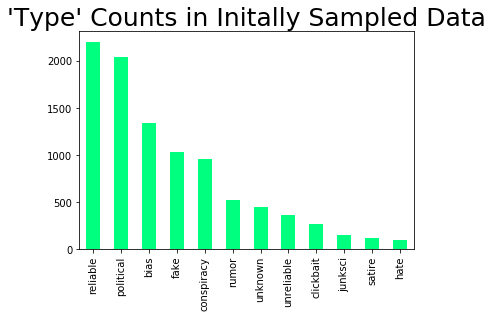

In [125]:
df.type.value_counts().plot(kind='bar',color='springgreen')
plt.title("'Type' Counts in Initally Sampled Data", fontsize=25)

Take the top four categories to make a new df. 

In [126]:
fake_new_df = df[df['type']== 'fake'].sample(n=1000, random_state=0)

bias_new_df = df[df['type']== 'bias'].sample(n=1000, random_state=0)

political_new_df = df[df['type']== 'political'].sample(n=1000, random_state=0)

reliable_new_df = df[df['type']== 'reliable'].sample(n=1000, random_state=0)

new_df = pd.concat([fake_new_df, reliable_new_df,bias_new_df,political_new_df])

Text(0.5, 1.0, "New 'Type' Counts in Sampled Data")

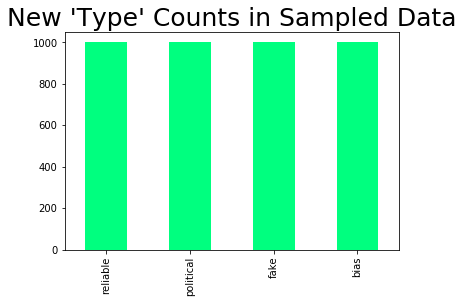

In [128]:
new_df.type.value_counts().plot(kind='bar',color='springgreen')
plt.title("New 'Type' Counts in Sampled Data", fontsize=25)

In [129]:
new_df.head()

y = new_df.type

X_train, X_test, y_train, y_test = train_test_split(new_df['content'], y, test_size=0.33, random_state=53)



Name of classifier being used with count vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.90      0.50      0.65       348
        fake       0.61      0.68      0.64       290
   political       0.54      0.75      0.63       335
    reliable       0.80      0.77      0.78       347

    accuracy                           0.68      1320
   macro avg       0.71      0.68      0.68      1320
weighted avg       0.72      0.68      0.68      1320


 Accuracy of classifier : 0.6757575757575758
                pred:fake  pred:political  pred:reliable  pred:bias
true:fake             198              64             22          6
true:political         43             252             30         10
true:reliable          35              42            267          3
true:bias              51             107             15        175
cv_Multino.png


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




Name of classifier being used with count vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.66      0.63      0.65       348
        fake       0.61      0.72      0.66       290
   political       0.60      0.56      0.58       335
    reliable       0.79      0.77      0.78       347

    accuracy                           0.67      1320
   macro avg       0.67      0.67      0.67      1320
weighted avg       0.67      0.67      0.67      1320


 Accuracy of classifier : 0.6666666666666666
                pred:fake  pred:political  pred:reliable  pred:bias
true:fake             208              32             19         31
true:political         60             186             29         60
t

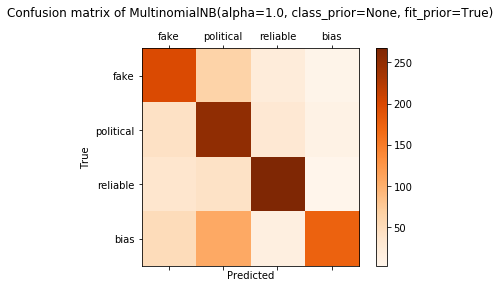

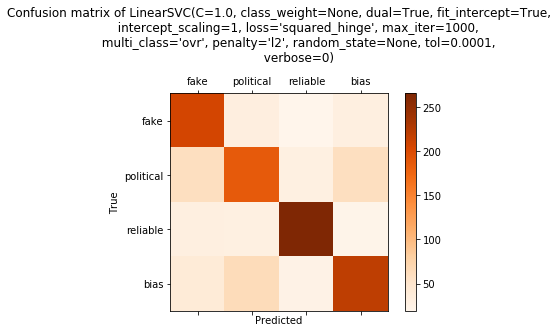

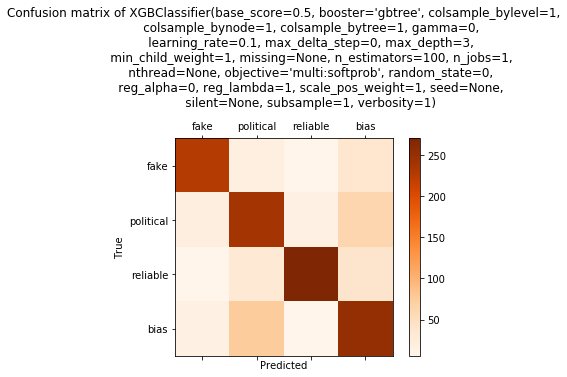

In [130]:
for classifier in classifiers:
    pipeline_w_cv = Pipeline([
              ('cv', CountVectorizer(stop_words='english')),
              ('clf',   classifier)])
    pipeline_w_cv.fit(X_train,y_train)
    y_pred = pipeline_w_cv.predict(X_test)
    print ("\n\nName of classifier being used with count vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(pipeline_w_cv.score(X_test,y_test)))
    labels = ['fake','political','reliable','bias']
    cmtx = pd.DataFrame(
        metrics.confusion_matrix(y_test, y_pred,  labels=labels), 
        index=['true:fake', 'true:political','true:reliable','true:bias' ], 
        columns=['pred:fake', 'pred:political', 'pred:reliable', 'pred:bias'])
    print(cmtx)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cmtx,cmap='Oranges')
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fig.colorbar(cax)
    plt.title('Confusion matrix of '+ str(classifier) + "\n")
    saveas = "cv_" + str(classifier)[0:7] +'.png'
    print (saveas)
    plt.savefig(saveas, bbox_inches='tight', dpi = 300)



Name of classifier being used with tfidf vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.91      0.48      0.63       348
        fake       0.66      0.63      0.64       290
   political       0.51      0.80      0.62       335
    reliable       0.80      0.78      0.79       347

    accuracy                           0.67      1320
   macro avg       0.72      0.67      0.67      1320
weighted avg       0.73      0.67      0.67      1320


 Accuracy of classifier : 0.671969696969697
                pred:fake  pred:political  pred:reliable  pred:bias
true:fake             182              78             23          7
true:political         36             268             25          6
true:reliable          19              56            269          3
true:bias              38             124             18        168
tfidf_Multi.png


Name of classifier 

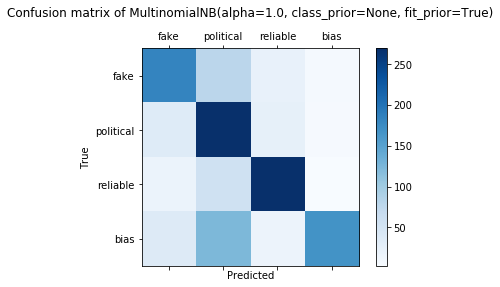

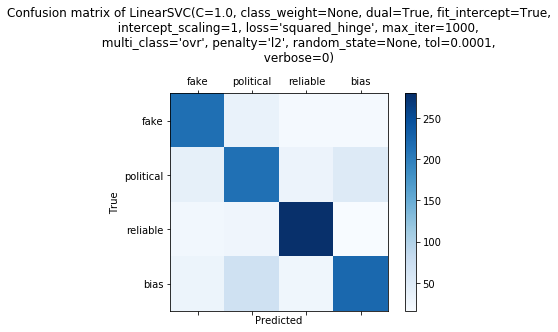

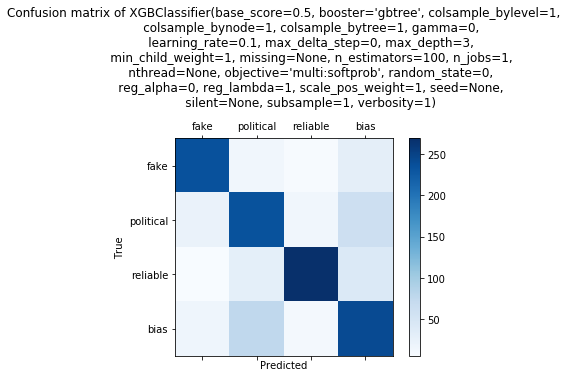

In [131]:
for classifier in classifiers:
    pipeline_w_tfidf = Pipeline([
              ('tfidf', TfidfVectorizer(stop_words='english')),
              ('clf',   classifier)])
    pipeline_w_tfidf.fit(X_train,y_train)
    y_pred = pipeline_w_tfidf.predict(X_test)
    print ("\n\nName of classifier being used with tfidf vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(pipeline_w_tfidf.score(X_test,y_test)))
    labels = ['fake','political','reliable','bias']
    cmtx = pd.DataFrame(
        metrics.confusion_matrix(y_test, y_pred,  labels=labels), 
        index=['true:fake', 'true:political','true:reliable','true:bias' ], 
        columns=['pred:fake', 'pred:political', 'pred:reliable', 'pred:bias'])
    print(cmtx)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cmtx,cmap='Blues')
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fig.colorbar(cax)
    plt.title('Confusion matrix of '+ str(classifier) + "\n")
    saveas = "tfidf_" + str(classifier)[0:5] +'.png'
    print (saveas)
    plt.savefig(saveas, bbox_inches='tight', dpi = 300)

### What happens when all of the original labels from the dataset are included in the classifier (not only 'fake','political','reliable','bias', but all of them)?

In [132]:
df = pd.read_csv('newly_sampled_data.csv')

In [133]:
df.shape

(10000, 16)

In [134]:
df = df[pd.notnull(df['content'])]

In [135]:
df = df[pd.notnull(df['type'])]

In [136]:
df.shape

(9528, 16)

Text(0.5, 1.0, "'Type' Counts in Initally Sampled Data")

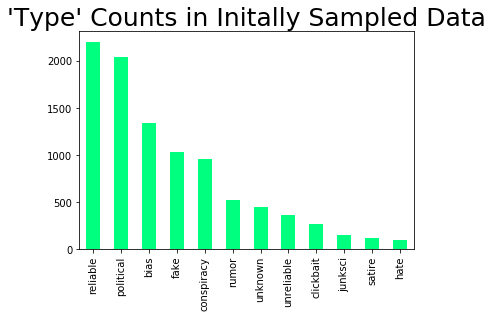

In [138]:
df.type.value_counts().plot(kind='bar',color='springgreen')
plt.title("'Type' Counts in Initally Sampled Data", fontsize=25)

In [139]:
df.type.value_counts()

reliable      2201
political     2040
bias          1342
fake          1031
conspiracy     954
rumor          523
unknown        449
unreliable     364
clickbait      268
junksci        145
satire         118
hate            93
Name: type, dtype: int64

In [140]:
y = df.type

X_train, X_test, y_train, y_test = train_test_split(df['content'], y, test_size=0.20, random_state=53)

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)




Name of classifier being used with count vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.72      0.55      0.63       258
   clickbait       1.00      0.02      0.04        52
  conspiracy       0.67      0.45      0.53       184
        fake       0.59      0.54      0.56       209
        hate       0.00      0.00      0.00        18
     junksci       0.89      0.23      0.36        35
   political       0.47      0.82      0.59       384
    reliable       0.67      0.84      0.74       463
       rumor       0.93      0.39      0.55       103
      satire       1.00      0.05      0.10        19
     unknown       0.88      0.23      0.36        92
  unreliable       1.00      0.67      0.81        89

    accuracy                           0.61      1906
   macro avg       0.73      0.40      0.44      1906
weighted avg       0.67      0.61      0.59  

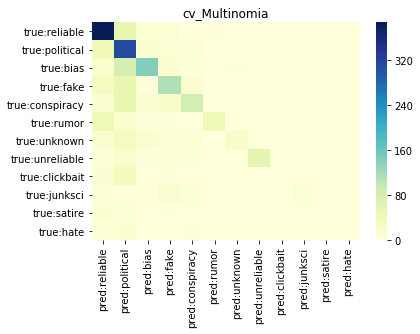

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




Name of classifier being used with count vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.58      0.57      0.58       258
   clickbait       0.29      0.27      0.28        52
  conspiracy       0.52      0.58      0.55       184
        fake       0.57      0.56      0.57       209
        hate       0.18      0.11      0.14        18
     junksci       0.67      0.46      0.54        35
   political       0.59      0.63      0.61       384
    reliable       0.80      0.80      0.80       463
       rumor       0.73      0.67      0.70       103
      satire       0.33      0.26      0.29        19
     unknown       0.36      0.39      0.37        92
  unreliable       0.88      0.69    

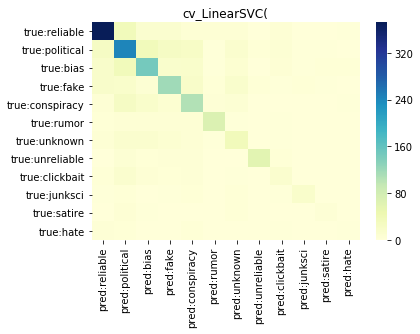



Name of classifier being used with count vectorizer: 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.79      0.55      0.65       258
   clickbait       1.00      0.27      0.42        52
  conspiracy       0.93      0.48      0.63       184
        fake       0.79      0.77      0.78       209
        hate       0.75      0.33      0.46        18
     junksci       0.86      0.51      0.64        35
   political       0.44      0.86      0.58       384
    reliable  

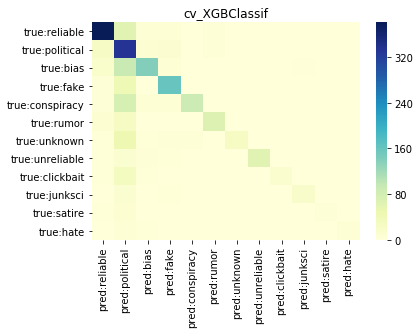

<Figure size 432x288 with 0 Axes>

In [141]:
for classifier in classifiers:
    pipeline_w_cv = Pipeline([
              ('cv', CountVectorizer(stop_words='english')),
              ('clf',   classifier)])
    pipeline_w_cv.fit(X_train,y_train)
    y_pred = pipeline_w_cv.predict(X_test)
    print ("\n\nName of classifier being used with count vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(pipeline_w_cv.score(X_test,y_test)))
    labels = ['reliable', 'political','bias','fake','conspiracy','rumor','unknown','unreliable', 'clickbait','junksci','satire','hate']
    cmtx = pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred,  labels=labels), 
    index=['true:reliable', 'true:political','true:bias','true:fake','true:conspiracy','true:rumor','true:unknown','true:unreliable', 'true:clickbait','true:junksci','true:satire','true:hate'], 
    columns=['pred:reliable', 'pred:political', 'pred:bias', 'pred:fake','pred:conspiracy','pred:rumor','pred:unknown','pred:unreliable','pred:clickbait','pred:junksci','pred:satire','pred:hate']
)
    print(cmtx)
    

    
    title = "cv_" + str(classifier)[0:10]
    
    
    
    ax = sns.heatmap(cmtx, cmap="YlGnBu")
    
    
    ax.set_title(title)

    saveas = "all_labels_cv_" + str(classifier)[0:5] +'.png'
    plt.show()
    ax.figure.savefig(saveas, bbox_inches='tight', dpi = 300)
    plt.clf()


 

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)




Name of classifier being used with tfidf vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.99      0.35      0.52       258
   clickbait       0.00      0.00      0.00        52
  conspiracy       1.00      0.24      0.39       184
        fake       1.00      0.08      0.15       209
        hate       0.00      0.00      0.00        18
     junksci       0.00      0.00      0.00        35
   political       0.36      0.84      0.50       384
    reliable       0.51      0.88      0.65       463
       rumor       1.00      0.03      0.06       103
      satire       0.00      0.00      0.00        19
     unknown       1.00      0.05      0.10        92
  unreliable       1.00      0.53      0.69        89

    accuracy                           0.49      1906
   macro avg       0.57      0.25      0.25      1906
weighted avg       0.69      0.49      0.42  

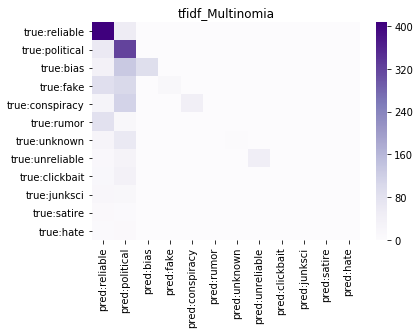



Name of classifier being used with tfidf vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.63      0.61      0.62       258
   clickbait       0.73      0.21      0.33        52
  conspiracy       0.67      0.58      0.62       184
        fake       0.70      0.72      0.71       209
        hate       0.40      0.11      0.17        18
     junksci       0.78      0.51      0.62        35
   political       0.57      0.77      0.65       384
    reliable       0.80      0.87      0.83       463
       rumor       0.77      0.77      0.77       103
      satire       0.83      0.26      0.40        19
     unknown       0.64      0.29      0.40        92
  unreliable       1.00      0.70    

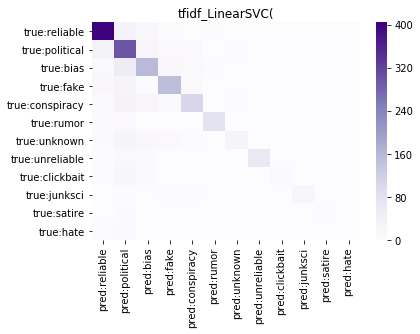



Name of classifier being used with tfidf vectorizer: 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.71      0.59      0.64       258
   clickbait       0.88      0.27      0.41        52
  conspiracy       0.79      0.50      0.61       184
        fake       0.87      0.80      0.83       209
        hate       0.83      0.28      0.42        18
     junksci       0.76      0.46      0.57        35
   political       0.49      0.85      0.62       384
    reliable  

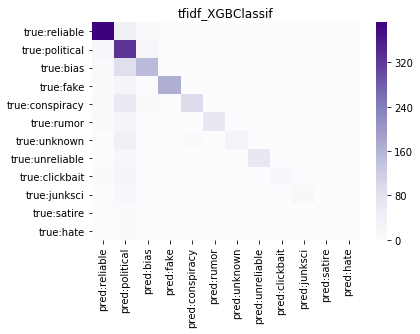

<Figure size 432x288 with 0 Axes>

In [142]:
for classifier in classifiers:
    pipeline_w_tfidf = Pipeline([
              ('tfidf', TfidfVectorizer()),
              ('clf',   classifier)])
    pipeline_w_tfidf.fit(X_train,y_train)
    y_pred = pipeline_w_tfidf.predict(X_test)
    print ("\n\nName of classifier being used with tfidf vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(pipeline_w_tfidf.score(X_test,y_test)))
    cmtx = pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred,  labels=labels), 
    index=['true:reliable', 'true:political','true:bias','true:fake','true:conspiracy','true:rumor','true:unknown','true:unreliable', 'true:clickbait','true:junksci','true:satire','true:hate'], 
    columns=['pred:reliable', 'pred:political', 'pred:bias', 'pred:fake','pred:conspiracy','pred:rumor','pred:unknown','pred:unreliable','pred:clickbait','pred:junksci','pred:satire','pred:hate']
)
    print(cmtx)
    
    
    
    title = "tfidf_" + str(classifier)[0:10]
    
    
    
    ax = sns.heatmap(cmtx, cmap="Purples")
    ax.set_title(title)
    
    
    
    plt.show()
    saveas = "all_labels_tfidf_" + str(classifier)[0:5] +'.png'
    ax.figure.savefig(saveas, bbox_inches='tight', dpi = 300)
    plt.clf()
 